# Plot free energy surfaces

In this notebook we plot the free energy surfaces onto different collective variables. First, we need to calculate different quantities from trajectories. This is a rather dull excercise, that we did in a separate [notebook](calculate_observables.ipynb). Here, we just read the data from pickle files

In [1]:
import pickle

# RMSD
fname = "data/observables/rmsd_full.p"
rmsd_full = pickle.load(open(fname,'rb'), encoding='bytes')

# RMSD
fname = "data/observables/rmsd_full_2koc.p"
rmsd_2koc = pickle.load(open(fname,'rb'), encoding='bytes')

fname = "data/observables/rmsd_full_6by5.p"
rmsd_6by5 = pickle.load(open(fname,'rb'), encoding='bytes')

# ERMSD
fname = "data/observables/ermsd_full.p"
ermsd_full = pickle.load(open(fname,'rb'), encoding='bytes')


# RMSD
fname = "data/observables/ermsd_full_2koc.p"
ermsd_2koc = pickle.load(open(fname,'rb'), encoding='bytes')

fname = "data/observables/ermsd_full_6by5.p"
ermsd_6by5 = pickle.load(open(fname,'rb'), encoding='bytes')

We now need to read the weights of the different ensembles. To complicate things, we have divided our dataset in 4 bins, so that we can estimate errors.

In [2]:
import numpy as np
weights = [[]for i in range(5)]

ss=["set_A","set_B","set_C","set_D"]
thetas = [20,40,60,500]
for i,el in enumerate(ss):
    for j in range(4):
        dd = np.array([[float(x) for x in line.split()] \
                       for line in open("data/my_theta/weights_%s_t_%d_rep_%d.dat" % (el,thetas[i],j))])
        if(i==0):
            weights[0].append(dd[:,0])
        weights[i+1].append(dd[:,1])

weights = np.array(weights)
print(weights.shape)

(5, 4, 25000)


We define a handy FES class, which essentially takes the weights, makes an histogram and returns the FES with lower and upper error bounds

In [3]:
from scipy import stats
import scipy
class FES:
    
    def __init__(self,data,ww,bw=0.1,blocks=4):   
        
        self.data = np.copy(data)
        self.ww = np.copy(ww)
        self.blocks=blocks
        bsize = int(data.shape[0]/blocks)
        self.bins = np.linspace(1.1*np.min(data),1.05*np.max(data),200)

        hists = []
        for j in range(blocks):
            st = j*bsize
            end = st + bsize
            f = bw/self.data[st:end].std()
            kernel = stats.gaussian_kde(data[st:end],weights=ww[j],bw_method=f)
            hh = kernel(self.bins)
            hists.append(hh)
        db = self.bins[1]-self.bins[0]
        self.hists = np.array(hists)*db
        
    def get_fes(self,temp=280,hist=False):
        
        kbt=0.008314462*temp
        
        avgs = np.average(self.hists,axis=0)
        stds = np.std(self.hists,axis=0,ddof=1)/np.sqrt(self.blocks)
        if(hist==True):
            return self.bins,avgs,avgs-stds,avgs+stds
        fes = -kbt*np.log(avgs)
        fes_up = -kbt*np.log(avgs  + stds)
        fes_low = -kbt*np.log(avgs  - stds)
        mm = np.min(fes)

        return self.bins,fes-mm,fes_low-mm,fes_up-mm
    
    def get_populations(self,r1):
        
        assert(r1[0]<r1[1])
        int1 = np.where((self.bins>r1[0]) & (self.bins<r1[1]))
        p1 = np.sum(self.hists[:,int1[0]],axis=1)/np.sum(self.hists,axis=1)
        return p1
    
    def get_df(self,r1,r2,temp=280):
    
        kbt=0.008314462*temp
        p1 = self.get_populations(r1)
        p2 = self.get_populations(r2)
        return -kbt*(np.log(p1) - np.log(p2))
    
    


We calculate the FES using projected onto the RMSD from native

In [4]:
fes_obj = []
for j in range(5):
    fes_obj.append(FES(rmsd_full,weights[j],bw=0.05))



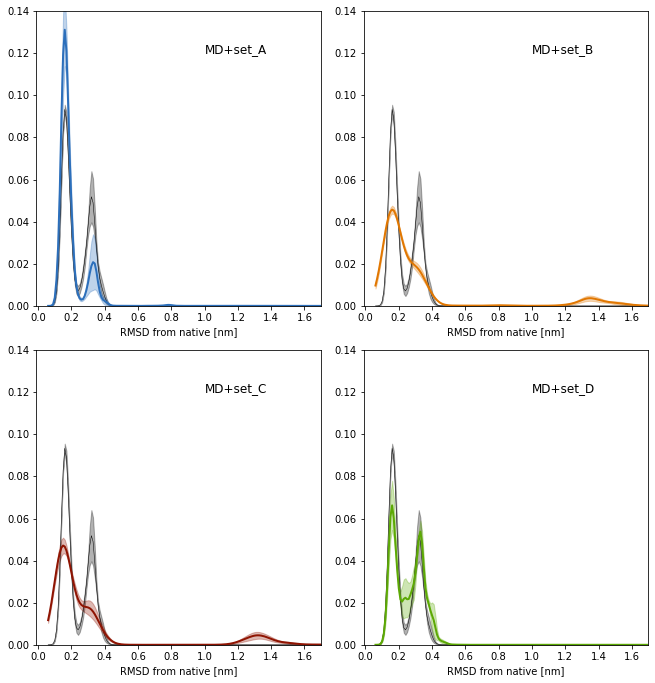

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
cols = ["black","medium blue","pumpkin","brick red","leaf green","white"]
cp = sns.xkcd_palette(cols)
fig,ax = plt.subplots(2,2,figsize=(10,10))
plt.subplots_adjust(left=0.1, bottom=0.07, right=0.95, top=0.95, wspace=0.15, hspace=0.15)
k = 0
for i in range(2):
    for j in range(2):
        ax[i,j].set_ylim(0.,0.14)
        ax[i,j].set_xlim(-0.01,1.7)

        bins0,fes0,fes0_up, fes0_low = fes_obj[0].get_fes(hist=True)
        bins1,fes1,fes1_up, fes1_low = fes_obj[k+1].get_fes(hist=True)
        ax[i,j].plot(bins0,fes0,label="MD",color=cp[0],lw=0.5)
        ax[i,j].fill_between(bins0,fes0_low,fes0_up,alpha=0.3,color=cp[0])
        ax[i,j].plot(bins1,fes1,label="MD+%s" % ss[k],color=cp[k+1],lw=2)
        ax[i,j].fill_between(bins1,fes1_low,fes1_up,alpha=0.3,color=cp[k+1])
        ax[i,j].text(1.0,0.12,"MD+%s" % ss[k],fontsize=12)
        ax[i,j].set_xlabel("RMSD from native [nm]")

        k+=1 
plt.savefig("RMSD_fes.pdf")
plt.savefig("RMSD_fes.png",dpi=600)
plt.show()
plt.close()

In our experience, the eRMSD better distinguishes conformations. Therefore, we use the eRMSD to calculate the histograms


In [6]:
fes_obj_ermsd = []
for j in range(5):
    fes_obj_ermsd.append(FES(ermsd_full,weights[j],bw=0.05))

In [7]:
fig,ax = plt.subplots(2,2,figsize=(4.5,4.5),sharex=True,sharey=True)
plt.subplots_adjust(left=0.1, bottom=0.12, right=0.95, top=0.95, wspace=0.16, hspace=0.1)
k = 0
cols = ["pumpkin","medium blue","dark grey","dark grey","dark grey","wine"]
cp = sns.xkcd_palette(cols)

stitles = ["set A","set B", "set C", "set D"]
kj = ["a","b","c",'d']
for i in range(2):
    for j in range(2):
        ax[i,j].set_ylim(-0.005,0.12)
        ax[i,j].set_xlim(-0.05,2.2)
        ax[i,j].set_yticks([0,0.04,0.08])
        bins0,fes0,fes0_up, fes0_low = fes_obj_ermsd[0].get_fes(hist=True)
        bins1,fes1,fes1_up, fes1_low = fes_obj_ermsd[k+1].get_fes(hist=True)
        ax[i,j].plot(bins0,fes0,label="MD",color=cp[0],lw=1.0)
        ax[i,j].fill_between(bins0,fes0_low,fes0_up,alpha=0.5,color=cp[0])
        ax[i,j].plot(bins1,fes1,label="MD+%s" % stitles[k],color=cp[k+1],lw=1)
        ax[i,j].fill_between(bins1,fes1_low,fes1_up,alpha=0.5,color=cp[k+1])
        #ax[i,j].text(1.0,0.09,"MD+%s" % stitles[k],fontsize=14,color=cp[k+1],weight="bold")
        ax[i,j].text(-0.2,0.11,kj[k],weight="bold",fontsize=12,ha="center",va="center")
        ax[i,j].legend(ncol=1)
        if(i==1): ax[i,j].set_xlabel("eRMSD from native [nm]")
        if(i==0 and j==0):
            #ax[i,j].scatter(ermsd_2koc,[-0.002]*len(ermsd_2koc),color=cp[5],label="2KOC",marker="x",s=40)
            ax[i,j].axvline(0.7,ls="--",lw=0.5,c="k")
            
        #ax[i,j].scatter(ermsd_6by5,[-0.002]*len(ermsd_6by5),color=cp[3],label="6BY5",marker="o",s=40)
        
        k+=1 
#plt.show()
plt.savefig("figures/figure3.pdf")
plt.savefig("figures/figure3.png",dpi=600)
#plt.show()
plt.close()



In [8]:
print("POPULATION of state A in different ensembles")
stitles2 = ["MD"] + stitles
for j in range(len(stitles2)):
    mean = 100*fes_obj_ermsd[j].get_populations([0,0.7]).mean()
    std = 100*fes_obj_ermsd[j].get_populations([0,0.7]).std(ddof=1)
    print("ensemble %s: %5.1f+/-%-5.1f" % (stitles2[j],mean,std))


POPULATION of state A in different ensembles
ensemble MD:  59.5+/-3.6  
ensemble set A:  83.4+/-15.5 
ensemble set B:  59.8+/-6.8  
ensemble set C:  64.9+/-5.1  
ensemble set D:  43.6+/-9.5  


Finally, we draw random samples from the refined MD+set A distribution and write PDB files to disk corresponding to state A and state B

In [9]:
# extract samples
import mdtraj as md
theta=20
top = "data/PDB/2koc_gmx.pdb"
trj = "data/traj_temp_f_0.xtc"

trajmd = md.load(trj,top=top)
native = "data/PDB/2koc_gmx.pdb"

# read weights 
data_tmp = np.array([[float(x) for x in line.split()] for line in open("data/my_theta/weights_%s_t_%d.dat" % (ss[0],theta),"r")])
weights1f = data_tmp[:,1]
# find indeces where ermsd is less than 0.7
stateAi = np.where(ermsd_full<0.7)[0]

# bootstrap samples
ff = np.random.choice(len(weights1f),size=100,p=weights1f/np.sum(weights1f),replace=False)

# write to disk 10 pdbs from each basin 
ac,bc = 0,0
for j in range(100):
    if(ff[j] in stateAi):
        trajmd[ff[j]].superpose(md.load(native)).save("stateA_sample%d.pdb" %ac)
        print("A",ermsd_full[ff[j]])
        ac += 1
    if(ff[j] not in stateAi):
        trajmd[ff[j]].superpose(md.load(native)).save("stateB_sample%d.pdb" %bc)
        print("B",ermsd_full[ff[j]])
        bc += 1


A 0.4528659230940923
A 0.5172693000054813
A 0.46994163911002346
A 0.48909671161983836
A 0.4822494049584679
A 0.4779707194931629
A 0.47389397212104845
B 0.9699579629408623
A 0.5293773279068776
A 0.4784953342974451
A 0.41652489368200507
B 0.8742469369563549
B 1.007886498997447
A 0.4690800993924569
A 0.5036068823800127
B 1.0854191933911157
A 0.42802007005981024
A 0.5309607484856222
A 0.5885664034899858
A 0.5130886789412261
A 0.4898599093335899
A 0.5042527015066893
A 0.5308605798432031
A 0.4611957547607218
A 0.47340451588340154
A 0.495105326109976
A 0.578490672722779
A 0.4816391467947763
A 0.49692979550146943
A 0.4301448805592902
A 0.5477131578796212
A 0.47213569008071854
A 0.5469255847229048
A 0.5006968737283022
A 0.3825115096065867
A 0.44555218614984005
A 0.48782639590931925
A 0.49198016766913105
A 0.5335115999712317
A 0.4966552223464603
A 0.49727872097314013
A 0.6064527485744277
A 0.4296260236910272
B 0.9807902969214174
A 0.45817839131923116
A 0.5602859597889019
A 0.4575331600205855
A 0